In [ ]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.7.0
Hub version: 0.12.0
GPU is available


In [ ]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import models, layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/pictures/RGB_wall/training",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 6171 files belonging to 6 classes.


In [ ]:
# let's check the cllasses names:
class_names = dataset.class_names
class_names

['Chlorophitum',
 'Monalisa',
 'Peperomia',
 'Philodendron',
 'Spathiphyllum',
 'Tradescantia']

In [ ]:
# Now all the data is arrange in  batches:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape) # shape of the batch (count, size, channels)
    print(labels_batch.numpy()) #(label = class)

(32, 256, 256, 3)
[0 0 4 1 3 4 5 4 5 5 2 3 3 5 2 1 5 1 5 3 4 3 3 3 4 2 3 4 2 0 1 3]


In [ ]:
# function who split the data into train set and vlidation set:
# when we dont want to split the data we eill use dataset = train_ds
def get_dataset_partitions_tf(ds, train_split=0.9, val_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)

    
    return train_ds, val_ds

In [ ]:
train_ds, val_ds = get_dataset_partitions_tf(dataset) # apply the function om our dataset

In [ ]:
# if we want to valid the model with different images (model 2):
train_ds = dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/pictures/RGB_wall/validation",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 621 files belonging to 6 classes.


In [ ]:
# now we want to import the test set that we created in seperate:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/pictures/RGB_wall/test",
    seed=123,
    shuffle=False, #keep it false for the confiusion matrix
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 107 files belonging to 6 classes.


In [ ]:
# prefetch - using the cpu to read the data ang gpu to train simultany - save time/
# cache - save time while loading the images
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_ds

<PrefetchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
# resize to 256*256, rescale the values

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
# flip the images for improving the accuracy of the model
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
# Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
193/193 [==============================] - 762s 939ms/step - loss: 0.8250 - accuracy: 0.6425 - val_loss: 0.9860 - val_accuracy: 0.6940
Epoch 2/50
193/193 [==============================] - 62s 319ms/step - loss: 0.2890 - accuracy: 0.8911 - val_loss: 2.2510 - val_accuracy: 0.5958
Epoch 3/50
193/193 [==============================] - 62s 319ms/step - loss: 0.1358 - accuracy: 0.9493 - val_loss: 1.5169 - val_accuracy: 0.7343
Epoch 4/50
193/193 [==============================] - 61s 317ms/step - loss: 0.0923 - accuracy: 0.9692 - val_loss: 0.8977 - val_accuracy: 0.8357
Epoch 5/50
193/193 [==============================] - 61s 317ms/step - loss: 0.0648 - accuracy: 0.9768 - val_loss: 0.9859 - val_accuracy: 0.8422
Epoch 6/50
193/193 [==============================] - 62s 321ms/step - loss: 0.0296 - accuracy: 0.9929 - val_loss: 1.6646 - val_accuracy: 0.8035
Epoch 7/50
193/193 [==============================] - 61s 318ms/step - loss: 0.0497 - accuracy: 0.9833 - val_loss: 1.5850 - val_a

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

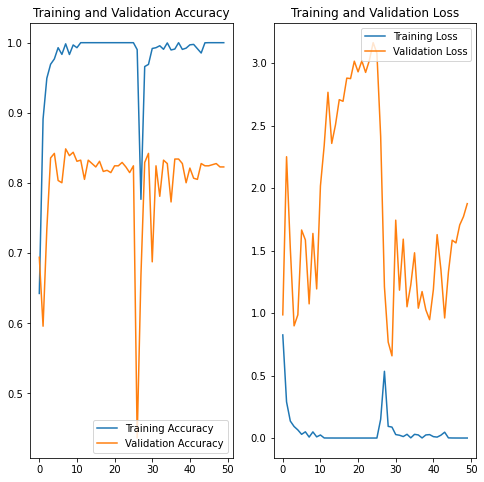

In [ ]:
# Plot the procces of the trainig and validating of the model
len_epoch = 50
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len_epoch),acc, label='Training Accuracy')
plt.plot(np.arange(len_epoch), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(np.arange(len_epoch), loss, label='Training Loss')
plt.plot(np.arange(len_epoch), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# saving the model when the validation images splited from video:
model.save("/content/drive/MyDrive/gdrive_folder/models/GW_classification.50_epoch")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/gdrive_folder/models/GW_classification.50_epoch/assets


In [ ]:
score = model.evaluate(test_ds)

4/4 [==============================] - 24s 175ms/step - loss: 0.8171 - accuracy: 0.9065
